##### import statements

In [1]:
# standard imports
import os

In [2]:
# third party imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or '1type

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

##### first step is to download the raw IMDB data and uncompress it. collecting individual training reviews into a list of strings, one string per review. collecting review labels into a labels list

In [5]:
# processing the labels of raw imdb data
imdb_dir = './../../data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

##### tokenizing the text of raw input data

In [6]:
maxlen = 100                        # Cuts off reviews after 100 words
training_samples = 8000              # Trains on 8000 samples
validation_samples = 10000          # Validates on 10,000 samples
max_words = 10000                   # Considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


##### Splits the data into a training set and a validation set, but first shuffles the data, because you’re starting with data in which samples are ordered (all negative first, then all positive) 

In [7]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

##### next step is to download GLOVE word embeddings and unzipping it

##### PREPROCESSING THE EMBEDDINGS

In [8]:
# Parsing the GloVe word-embeddings file
glove_dir = './../../data'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


##### Next, you’ll build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference word index (built during tokenization). Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholder

In [9]:
# Preparing the GloVe word-embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [10]:
# defining the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [11]:
# LOADING THE GLOVE EMBEDDINGS IN THE MODEL
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [12]:
# training and evaluation
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 8000 samples, validate on 10000 samples
Epoch 1/20
8000/8000 [==============================] - 1s 103us/step - loss: 0.7173 - acc: 0.5707 - val_loss: 0.6555 - val_acc: 0.6478
Epoch 2/20
8000/8000 [==============================] - 1s 82us/step - loss: 0.5962 - acc: 0.6939 - val_loss: 0.6027 - val_acc: 0.6741
Epoch 3/20
8000/8000 [==============================] - 1s 75us/step - loss: 0.5104 - acc: 0.7562 - val_loss: 0.5810 - val_acc: 0.6975
Epoch 4/20
8000/8000 [==============================] - 1s 71us/step - loss: 0.4380 - acc: 0.7979 - val_loss: 0.6031 - val_acc: 0.6928
Epoch 5/20
8000/8000 [==============================] - 1s 70us/step - loss: 0.3774 - acc: 0.8350 - val_loss: 0.6018 - val_acc: 0.7041
Epoch 6/20
8000/8000 [==============================] - 1s 72us/step - loss: 0.3232 - acc: 0.8669 - val_loss: 0.6806 - val_acc: 0.6902
Epoch 7/20
8000/8000 [==============================] - 1s 71us/step - loss: 0.2621 - acc: 0

In [13]:
##### plotting the results

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

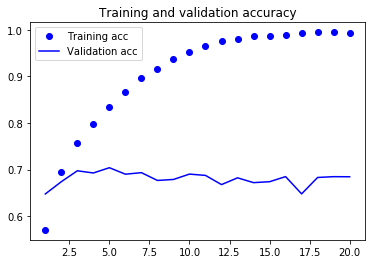

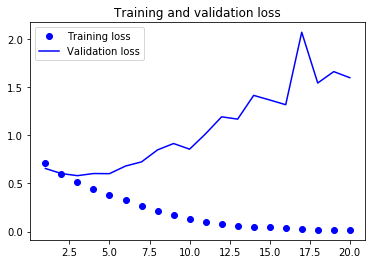

In [15]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()